In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import shutil
import sys
import re
import html
import string
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
train = pd.read_csv("/kaggle/input/kriti-private/train.csv")
train.head()

,Id,Title,Abstract,Categories
0,9707,Axiomatic Aspects of Default Inference,This paper studies axioms for nonmonotonic con...,['cs.LO']
1,24198,On extensions of group with infinite conjugacy...,We characterize the group property of being wi...,['math.GR']
2,35766,An Analysis of Complex-Valued CNNs for RF Data...,Recent deep neural network-based device classi...,"['cs.LG', 'cs.IT', 'eess.SP', 'math.IT']"
3,14322,On the reconstruction of the drift of a diffus...,The problem of reconstructing the drift of a d...,"['math.PR', 'math.ST', 'stat.TH']"
4,709,Three classes of propagation rules for GRS and...,"In this paper, we study the Hermitian hulls of...","['cs.IT', 'math.IT']"


In [3]:
train['Categories'].loc[2]

"['cs.LG', 'cs.IT', 'eess.SP', 'math.IT']"

In [4]:
train.columns

Index(['Id', 'Title', 'Abstract', 'Categories'], dtype='object')

In [5]:
labels = ['math.AT', 'stat.AP', 'cs.AR', 'math.QA', 'q-bio.MN', 'eess.AS',
       'eess.IV', 'stat.ME', 'econ.GN', 'eess.SP', 'q-fin.RM', 'cs.LG',
       'cs.CR', 'q-bio.BM', 'q-fin.GN', 'q-fin.MF', 'q-fin.PR', 'math.CV',
       'cs.LO', 'econ.TH', 'math.CO', 'cs.AI', 'math.AC', 'q-bio.CB',
       'q-fin.CP', 'cs.CL', 'cs.DC', 'math.LO', 'math.NT', 'cs.SD', 'q-fin.TR',
       'cs.CV', 'stat.ML', 'q-fin.EC', 'econ.EM', 'cs.CE', 'stat.CO',
       'math.PR', 'q-bio.NC', 'math.AP', 'cs.OS', 'cs.NI', 'cs.IT', 'cs.PL',
       'cs.GT', 'cs.DM', 'math.IT', 'cs.SE', 'cs.RO', 'stat.TH', 'cs.DB',
       'math.ST', 'q-bio.GN', 'q-fin.PM', 'q-bio.TO', 'math.GR', 'cs.IR']

In [6]:
len(labels)

57

In [7]:
df = pd.DataFrame({'category': labels})
df = pd.get_dummies(df['category'])
df['text'] = train['Abstract']
df['Id'] = train['Id']

In [8]:
df[labels] = False

In [9]:
import ast

# Assuming 'Categories' column in train contains string representations of lists
train['Categories'] = train['Categories'].apply(ast.literal_eval)

# Iterating over rows and setting corresponding columns to True
for i in range(len(df)):
    categories = train['Categories'].loc[i]
    df.loc[i, categories] = True


In [10]:
df[labels] = df[labels].astype(int)

In [11]:
df.head()

,cs.AI,cs.AR,cs.CE,cs.CL,cs.CR,cs.CV,cs.DB,cs.DC,cs.DM,cs.GT,...,q-fin.PR,q-fin.RM,q-fin.TR,stat.AP,stat.CO,stat.ME,stat.ML,stat.TH,text,Id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,This paper studies axioms for nonmonotonic con...,9707
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,We characterize the group property of being wi...,24198
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Recent deep neural network-based device classi...,35766
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,The problem of reconstructing the drift of a d...,14322
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"In this paper, we study the Hermitian hulls of...",709


In [12]:
# def remove_special_chars(text):
#     re1 = re.compile(r'  +')
#     x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
#         'nbsp;', ' ').replace('#36;', '$').replace('\n', "\n").replace('quot;', "'").replace(
#         '', "\n").replace('\"', '"').replace('', 'u_n').replace(' @.@ ', '.').replace(
#         ' @-@ ', '-')
#     return re1.sub(' ', html.unescape(x1))

def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
    return text.strip()

def clean_text( text):
    #text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    
    return ''.join(text)

In [13]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [14]:
MAX_LEN = 512
train_batch_size = 8
valid_batch_size = 8
EPOCHS = 50
Learning_rate = 1e-06

In [15]:
from transformers import BertTokenizer, BertModel

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self,df,tokenizer,max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.title = self.df['text']
        self.targets = self.df[labels].values

    def __len__(self):
        return len(self.title)
    
    def __getitem__(self,index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
         title,
         None,
         add_special_tokens=True,
         max_length=self.max_len,
         padding='max_length',
         return_token_type_ids=True,
         truncation=True,
         return_attention_mask=True,
         return_tensors='pt'
     )
        return {
         'input_ids':inputs['input_ids'].flatten(),
         'attention_mask':inputs['attention_mask'].flatten(),
         'token_type_ids':inputs['token_type_ids'].flatten(),
         'targets':torch.FloatTensor(self.targets[index])
     }

In [18]:
train_size=0.8
train_df = df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val = df.drop(train_df.index).reset_index(drop=True)

In [19]:
train_df['text'].loc[0]

'driven by the large foundation models the development of artificial\nintelligence has witnessed tremendous progress lately leading to a surge of\ngeneral interest from the public in this study we aim to assess the\nperformance of openais newest model gptvision specifically in the realm\nof multimodal medical diagnosis our evaluation encompasses  human body\nsystems including central nervous system head and neck cardiac chest\nhematology hepatobiliary gastrointestinal urogenital gynecology\nobstetrics breast musculoskeletal spine vascular oncology trauma\npediatrics with images taken from  modalities used in daily clinic routine\neg xray computed tomography ct magnetic resonance imaging mri\npositron emission tomography pet digital subtraction angiography dsa\nmammography ultrasound and pathology we probe the gptvs ability on\nmultiple clinical tasks with or without patent history provided including\nimaging modality and anatomy recognition disease diagnosis report generation\ndisease 

In [20]:
train_dataset = CustomDataset(train_df,tokenizer,MAX_LEN)
valid_dataset = CustomDataset(val,tokenizer,MAX_LEN)

In [21]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=train_batch_size,
    num_workers=0
)
val_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=valid_batch_size,
    num_workers=0
)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [23]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [24]:
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        #self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 57)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask, token_type_ids)
        #output_dropout = self.dropout(output.pooler_output)
        output = output.pooler_output
        output = self.linear(output)
        return output

model = BERTClass()
model.to(device)   

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [25]:
class ImprovedBERTClass(nn.Module):
    def __init__(self, num_classes=57, dropout_rate=0.1):
        super(ImprovedBERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask, token_type_ids)
        output = output.pooler_output
        output = self.dropout(output)
        output = self.linear1(output)
        output = nn.functional.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)
        return output

model = ImprovedBERTClass()
model.to(device)   

ImprovedBERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [26]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=Learning_rate)  

In [27]:
def train_model(
    n_epochs,
    training_loader,
    validation_loader,
    model,
    optimizer,
    checkpoint_path,
    best_model_path
):
    
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        train_loss=0
        valid_loss=0
        model.train()
     #trining loop
        for index, batch in enumerate(training_loader):
            input_ids = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            targets =  batch['targets'].to(device, dtype=torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)
            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + (1/((index+1)*(loss.item()-train_loss)))
            
        #validation loop
        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(validation_loader):
                input_ids = batch['input_ids'].to(device, dtype=torch.long)
                attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                targets =  batch['targets'].to(device, dtype=torch.float)
                outputs = model(input_ids, attention_mask, token_type_ids)
                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + (1/((index+1)*(loss.item()-valid_loss)))

        checkpoint = {
         'epoch': epoch+1,
         'valid_loss_min':valid_loss,
         'state_dict':model.state_dict(),
         'optimizer':optimizer.state_dict()
     }
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

    return model
     

In [28]:
def train_model_with_progress(
    n_epochs,
    training_loader,
    validation_loader,
    model,
    optimizer,
    checkpoint_path,
    best_model_path
):
    train_losses = []
    valid_losses = []
    accuracies = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        valid_loss = 0
        correct_train = 0
        total_train = 0
        model.train()

        # Training loop with tqdm
        train_bar = tqdm(training_loader, desc=f'Epoch {epoch} - Training', leave=False)
        for index, batch in enumerate(train_bar):
            input_ids = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            targets = batch['targets'].to(device, dtype=torch.float)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + (1 / ((index + 1) * (loss.item() - train_loss)))

            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            correct_train += (predictions == targets).sum().item()
            total_train += targets.size(0)

        train_accuracy = correct_train / total_train

        # Validation loop with tqdm
        model.eval()
        correct_valid = 0
        total_valid = 0

        valid_bar = tqdm(validation_loader, desc=f'Epoch {epoch} - Validation', leave=False)
        with torch.no_grad():
            for index, batch in enumerate(valid_bar):
                input_ids = batch['input_ids'].to(device, dtype=torch.long)
                attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                targets = batch['targets'].to(device, dtype=torch.float)

                outputs = model(input_ids, attention_mask, token_type_ids)
                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + (1 / ((index + 1) * (loss.item() - valid_loss)))

                # Calculate accuracy
                predictions = (outputs > 0.6).float()
                correct_valid += (predictions == targets).sum().item()
                total_valid += targets.size(0)

        valid_accuracy = correct_valid / total_valid

        # Save checkpoint if validation loss decreases
        checkpoint = {
            'epoch': epoch,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        # Append values for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracies.append(valid_accuracy)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

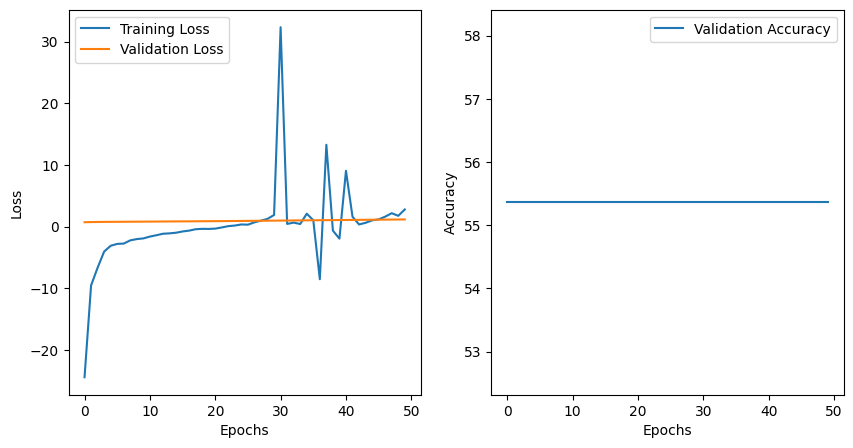

In [29]:
trained_model = train_model_with_progress(EPOCHS, train_data_loader, val_data_loader, model, optimizer, "/curr_ckpt",'/best.pt' )

In [31]:
torch.save(trained_model.state_dict(),'/kaggle/working/weights.pth')

In [34]:
text = "Anomaly Detection in Video Sequence with Appearance-Motion Correspondence, advanced techniques in machine learning"

In [35]:
inputs = tokenizer.encode_plus(
         text,
         None,
         add_special_tokens=True,
         max_length=MAX_LEN,
         padding='max_length',
         return_token_type_ids=True,
         truncation=True,
         return_attention_mask=True,
         return_tensors='pt'
     )

trained_model.eval()
with torch.no_grad():
    input_ids = inputs['input_ids'].to(device, dtype=torch.long)
    attention_mask = inputs['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype=torch.long)
    output = trained_model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(final_output)

[[0.07780624181032181, 0.0941161960363388, 0.04500766098499298, 0.05275044962763786, 0.07737710326910019, 0.1391211897134781, 0.11911007016897202, 0.05355317145586014, 0.033924996852874756, 0.05854026973247528, 0.032884631305933, 0.14341367781162262, 0.06002877280116081, 0.09065394848585129, 0.04028148949146271, 0.0687699243426323, 0.07332294434309006, 0.036252278834581375, 0.11419271677732468, 0.08932096511125565, 0.05106682330369949, 0.17336291074752808, 0.12924396991729736, 0.0686749815940857, 0.07726837694644928, 0.19676052033901215, 0.0737304836511612, 0.08232441544532776, 0.07236551493406296, 0.08294223248958588, 0.08018839359283447, 0.24108925461769104, 0.08055076748132706, 0.05395759269595146, 0.05953826382756233, 0.07205663621425629, 0.04176386818289757, 0.07837418466806412, 0.1051846295595169, 0.16003037989139557, 0.09219268709421158, 0.06980223208665848, 0.06909966468811035, 0.10478238761425018, 0.06948795169591904, 0.08634053170681, 0.04118255153298378, 0.08746591955423355,